# Extrinsic analysis

**Input files of this notebook:**
* `../config.yml`
* `../data/osm_{study_area}.graphml`
* `../data/osm_{study_area}_simple.graphml`
* `../data/ref_{study_area}.graphml`
* `../data/ref_{study_area}_simple.graphml`
* `../data/grid_{study_area}.gpkg`
* `../data/osm_nodes_{study_area}.pickle`
* `../data/osm_edges_{study_area}.pickle`
* `../data/osm_nodes_simplified_{study_area}.pickle`
* `../data/osm_edges_simplified_{study_area}.pickle`
* `../data/osm_nodes_joined{study_area}.pickle`
* `../data/osm_edges_joined{study_area}.pickle`
* `../data/osm_nodes_simplified_joined_{study_area}.pickle`
* `../data/osm_edges_simplified_joined_{study_area}.pickle`
* `../data/ref_nodes_{study_area}.pickle`
* `../data/ref_edges_{study_area}.pickle`
* `../data/ref_nodes_simplified_{study_area}.pickle`
* `../data/ref_edges_simplified_{study_area}.pickle`
* `../data/ref_nodes_joined_{study_area}.pickle`
* `../data/ref_edges_joined_{study_area}.pickle`
* `../data/ref_nodes_simplified_joined_{study_area}.pickle`
* `../data/ref_edges_simplified_joined_{study_area}.pickle`

**Output files of this notebook:**
* `../results/extrinsic_analysis_{study_area}.json`
* `../results/grid_results_extrinsic_{study_area}.pickle`

**Overview**

This notebook contrasts and compares the OSM data on cycling infrastructure for a given area with a reference data set. To run this analysis, a reference data set must be available for comparison. It should contain the same type of features for the comparison to make sense. 

*@Ane I'm not sure what you mean here? (maybe it's just my lack of intuition to what "features" or "type of features" would typically mean in this context) you had the "(i.e. in the ideal world be identical to the data downloaded from OSM)" sentence but in an ideal world the reference data set would be maybe even better than OSM?*

The analysis is based on comparing OSM data to the reference dataset and highlighting how and where they differ, not only comparing *how much* cycling infrastructure is mapped in the two datasets, but also comparing *how* the infrastructure is mapped (e.g. looking at differing network topology and structure).

While the analysis is based on a comparison, we make no a priori assumptions about which dataset is better. The same goes for the identified differences: the workflow does not lead to an automatic conclusion as to which data set is of better quality, but instead requires the user to interpret the meaning of the differences found; e.g. whether differing features are results of errors of omission or comission, and which dataset is more correct.

The goal is that the identified differences can be used by the user to both assess the quality of the OSM and the reference datasets, and to support the decision of which dataset should be used for further analysis, if any.

**For a correct interpretation of some of the metrics for spatial data quality, some familiarity with the area is necessary.**

**Sections:**

1. Load and process data
2. Data completeness
    - Network length
    - Network densities
        - Global network density
        - Local network density
        - Density of protected vs. unprotected infrastructure
3. Network structure
    - Alpha, beta and gamma values
    - Simplification outcomes
    - Number of nodes and edges per infrastructure length
    - Local node/edge ratio
4. Network topology
    - Dangling nodes
    - Over and undershoots
5. Network component analysis
    - Number of connected components
    - Component size distribution
    - Largest connected component
    - Edge number distribution
    - Grid cells with more than one component
    - Component connectivity
6. Save Results

_________________________

## 1. Load and process data

In [25]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import yaml
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import contextily as cx
import json
import pickle
import folium
from src import evaluation_functions as ef
from src import graph_functions as gf
import numpy as np

### Load settings

In [2]:
with open(r'../config.yml') as file:

    parsed_yaml_file = yaml.load(file, Loader=yaml.FullLoader)

    study_area = parsed_yaml_file['study_area']
    study_area_poly_fp = parsed_yaml_file['study_area_poly']
    study_crs = parsed_yaml_file['study_crs']

    missing_tag_dict = parsed_yaml_file['missing_tag_analysis']

    incompatible_tags_dict = parsed_yaml_file['incompatible_tags_analysis']

    cycling_infrastructure_queries = parsed_yaml_file['cycling_infrastructure_queries']

    reference_geometries = parsed_yaml_file['reference_geometries']
    cycling_bidirectional = parsed_yaml_file['bidirectional']
    
print('Settings loaded!')

Settings loaded!


### Load OSM and reference graphs and grid

In [3]:
# Load simplified and non-simplified graphs
osm_graph = ox.load_graphml(
    f'../data/osm_{study_area}.graphml', 
    edge_dtypes={'cycling_bidirectional': ox.io._convert_bool_string})

osm_simplified_graph = ox.load_graphml(
    f'../data/osm_{study_area}_simple.graphml', 
    edge_dtypes={'cycling_bidirectional': ox.io._convert_bool_string, 
    'infrastructure_length':float})

ref_graph = ox.load_graphml(f'../data/ref_{study_area}.graphml')
ref_simplified_graph = ox.load_graphml(
    f'../data/ref_{study_area}_simple.graphml',
    edge_dtypes={'infrastructure_length':float})

print('Graphs loaded!')

# Load grid
grid = gpd.read_file(f'../data/grid_{study_area}.gpkg')
grid_ids = grid.grid_id.to_list()

with open(f'../data/osm_nodes_{study_area}.pickle', 'rb') as fp:
    osm_nodes = pickle.load(fp)

with open(f'../data/osm_edges_{study_area}.pickle', 'rb') as fp:
    osm_edges = pickle.load(fp)

with open(f'../data/osm_nodes_simplified_{study_area}.pickle', 'rb') as fp:
    osm_nodes_simplified = pickle.load(fp)

with open(f'../data/osm_edges_simplified_{study_area}.pickle', 'rb') as fp:
    osm_edges_simplified = pickle.load(fp)

# Joined data
with open(f'../data/osm_nodes_joined_{study_area}.pickle', 'rb') as fp:
    osm_nodes_joined = pickle.load(fp)

with open(f'../data/osm_edges_joined_{study_area}.pickle', 'rb') as fp:
    osm_edges_joined = pickle.load(fp)

with open(f'../data/osm_nodes_simplified_joined_{study_area}.pickle', 'rb') as fp:
    osm_nodes_simp_joined = pickle.load(fp)

with open(f'../data/osm_edges_simplified_joined_{study_area}.pickle', 'rb') as fp:
    osm_edges_simp_joined = pickle.load(fp)

print('OSM data loaded!')

with open(f'../data/ref_nodes_{study_area}.pickle', 'rb') as fp:
    ref_nodes = pickle.load(fp)

with open(f'../data/ref_edges_{study_area}.pickle', 'rb') as fp:
    ref_edges = pickle.load(fp)

with open(f'../data/ref_nodes_simplified_{study_area}.pickle', 'rb') as fp:
    ref_nodes_simplified = pickle.load(fp)

with open(f'../data/ref_edges_simplified_{study_area}.pickle', 'rb') as fp:
    ref_edges_simplified = pickle.load(fp)

# Joined data
with open(f'../data/ref_nodes_joined_{study_area}.pickle', 'rb') as fp:
    ref_nodes_joined = pickle.load(fp)

with open(f'../data/ref_edges_joined_{study_area}.pickle', 'rb') as fp:
    ref_edges_joined = pickle.load(fp)

with open(f'../data/ref_nodes_simplified_joined_{study_area}.pickle', 'rb') as fp:
    ref_nodes_simp_joined = pickle.load(fp)

with open(f'../data/ref_edges_simplified_joined_{study_area}.pickle', 'rb') as fp:
    ref_edges_simp_joined = pickle.load(fp)

print('Reference data loaded!')

# Dictionaries for saving data
all_results = {}
results_ref = {}
results_osm = {}

Graphs loaded!
OSM data loaded!
Reference data loaded!


### Load dictionary of folium TileLayers

In [4]:
folium_layers = {
        'Google Satellite': folium.TileLayer(
                tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
                attr = 'Google',
                name = 'Google Satellite',
                overlay = True,
                control = True,
                show = False
                ),
        'whiteback': folium.TileLayer(
                tiles = 'https://api.mapbox.com/styles/v1/krktalilu/ckrdjkf0r2jt217qyoai4ndws/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1Ijoia3JrdGFsaWx1IiwiYSI6ImNrcmRqMXdycTB3NG8yb3BlcGpiM2JkczUifQ.gEfOn5ttzfH5BQTjqXMs3w',
                name = 'Background: White',
                attr = 'Mapbox',
                control = True,
                overlay = True,
                show = False
                ),
        'Stamen TonerLite': folium.TileLayer(
                tiles = 'https://stamen-tiles-{s}.a.ssl.fastly.net/toner-lite/{z}/{x}/{y}{r}.png',
                attr = 'Map tiles by <a href="http://stamen.com">Stamen Design</a>, <a href="http://creativecommons.org/licenses/by/3.0">CC BY 3.0</a> &mdash; Map data &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
                name = 'Stamen TonerLite',
                control = True,
                overlay = True,
                show = False
        ), 
        'CyclOSM': folium.TileLayer(
                tiles = 'https://{s}.tile-cyclosm.openstreetmap.fr/cyclosm/{z}/{x}/{y}.png',
                attr = 'Map data &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
                name = 'CyclOSM',
                control = True,
                overlay = True,
                show = False
        ),     
        'OSM': folium.TileLayer(
                tiles = 'openstreetmap', 
                name = 'OpenStreetMap',
                attr = 'Map data &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
                control = True, 
                overlay = True
                )
}

### Plot data

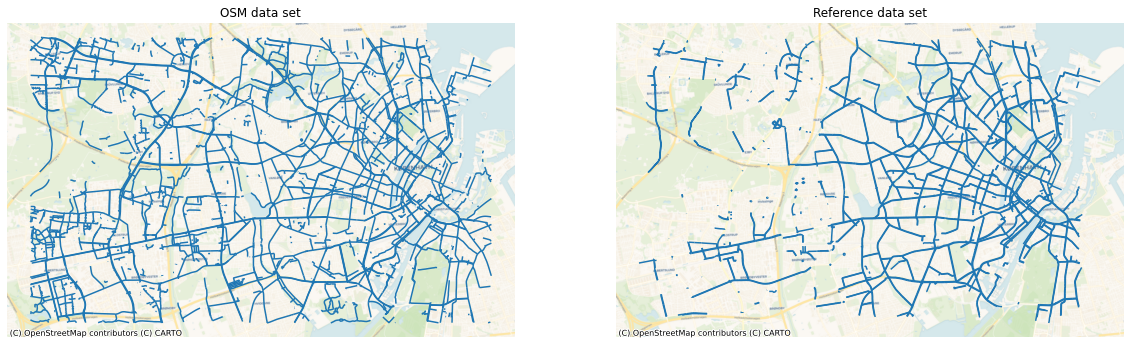

In [5]:
fig, ax = plt.subplots(1,2,figsize=(20,10))

# OSM
i = 0
osm_edges_simplified.plot(ax = ax[i])
cx.add_basemap(ax = ax[i], crs=study_crs, source=cx.providers.CartoDB.Voyager)
ax[i].set_title('OSM data set')
ax[i].set_axis_off()

# REF
i = 1
ref_edges_simplified.plot(ax = ax[i])
cx.add_basemap(ax = ax[i], crs=study_crs, source=cx.providers.CartoDB.Voyager)
ax[i].set_title('Reference data set')
ax[i].set_axis_off()

_________________

## 2. Data completeness

This section compares the two datasets in terms of completeness. The goal is to identify whether one dataset has more cycling infrastructure mapped than the other, and if so, whether those differences are concentrated in some areas.

To account for differences in how cycling infrastructure has been mapped, the computation of network length and density is based on the infrastructure length, not the geometric length of the network edges. For example, a 100 meter long **bi**directional path (geometric length: 100m) contributes with 200 meters of cycling infrastructure (infrastructure length: 200m).

### Why?

### How?

### What could it mean?

### Network length

In [6]:
ref_length = ref_edges_simplified.infrastructure_length.sum()
osm_length = osm_edges_simplified.infrastructure_length.sum()

h = max([ref_length, osm_length])
l = min([ref_length, osm_length])

diff = h - l

percent_diff = (osm_length - ref_length) / osm_length * 100

basel = diff / l * 100 # High is x percent higher than l
baseh = diff / h * 100 # Low is x percent lower than h

if ref_length > osm_length:
    hlab = "reference"
    llab = "OSM"
elif osm_length > ref_length:
    hlab = "OSM"
    llab = "reference"

print(f'Length of the OSM data set: {osm_length/1000:.2f} km')
print(f'Length of the reference data set: {ref_length/1000:.2f} km')
print("\n")
print(f'The {hlab} data set is {diff/1000:.2f} km longer than the {llab} data set.')
print(f'The {llab} data set is {diff/1000:.2f} km shorter than the {hlab} data set.')
print("\n")
print(f'The {hlab} data set is {baseh:.2f}% longer than the {llab} data set.')
print(f'The {llab} data set is {basel:.2f}% shorter than the {hlab} data set.')

# @Ane: choose which one you like better :) 

all_results['ref_infra_length_m'] = ref_length
all_results['osm_infra_length_m'] = osm_length
all_results['length_difference_osm_ref'] = diff
all_results['pct_length_difference'] = percent_diff


Length of the OSM data set: 1065.06 km
Length of the reference data set: 623.52 km


The OSM data set is 441.54 km longer than the reference data set.
The reference data set is 441.54 km shorter than the OSM data set.


The OSM data set is 41.46% longer than the reference data set.
The reference data set is 70.81% shorter than the OSM data set.


### Network Densities

#### Why?

#### How?

#### What could it mean?

#### Global Network Density

In [7]:
### OSM
osm_edge_density, osm_node_density, osm_dangling_node_density = ef.compute_network_density(
    (osm_edges_simplified, osm_nodes_simplified),
    grid.unary_union.area, 
    return_dangling_nodes=True)

results_osm['edge_density_m_sqkm'] = osm_edge_density
results_osm['node_density_sqkm'] = osm_node_density
results_osm['dangling_node_density_sqkm'] = osm_dangling_node_density

print(f'For the entire study area, there are {osm_edge_density:.2f} meters of cycling infrastructure per square km in OSM')
print(f'For the entire study area, there are {osm_node_density:.2f} nodes in the cycling network per square km in OSM')
print(f'For the entire study area, there are {osm_dangling_node_density:.2f} dangling nodes in the cycling network per square km in OSM')


For the entire study area, there are 5871.84 meters of cycling infrastructure per square km in OSM
For the entire study area, there are 26.13 nodes in the cycling network per square km in OSM
For the entire study area, there are 9.86 dangling nodes in the cycling network per square km in OSM


In [8]:
### REF
ref_edge_density, ref_node_density, ref_dangling_node_density = ef.compute_network_density(
    (ref_edges_simplified, ref_nodes_simplified),
    grid.unary_union.area, 
    return_dangling_nodes=True)
    
results_ref['edge_density_m_sqkm'] = ref_edge_density
results_ref['node_density_sqkm'] = ref_node_density
results_ref['dangling_node_density_sqkm'] = ref_dangling_node_density

print(f'For the entire study area, there are {ref_edge_density:.2f} meters of cycling infrastructure per square km in the reference data')
print(f'For the entire study area, there are {ref_node_density:.2f} nodes in the cycling network per square km in the reference data')
print(f'For the entire study area, there are {ref_dangling_node_density:.2f} dangling nodes in the cycling network per square km in the reference data')



For the entire study area, there are 3437.55 meters of cycling infrastructure per square km in the reference data
For the entire study area, there are 20.15 nodes in the cycling network per square km in the reference data
For the entire study area, there are 4.81 dangling nodes in the cycling network per square km in the reference data


##### Global differences in network density

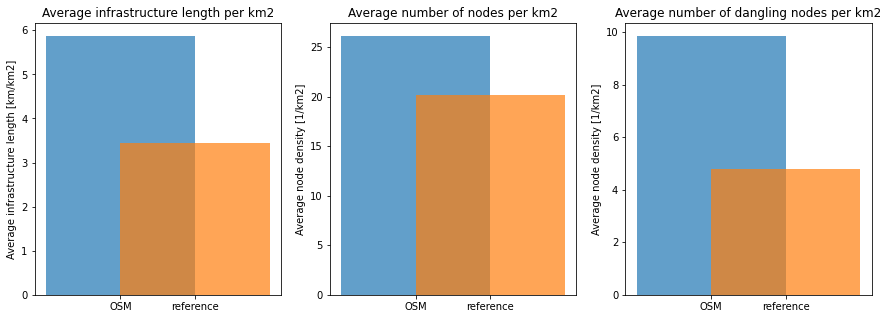

In [9]:
# PLOT GLOBAL DIFFERENCES 

fig, ax = plt.subplots(1,3,figsize=(15,5))
bars = ('OSM', 'reference')
y_pos = [0.75,1]

# Infrastructure length
i = 0
ax[i].bar(y_pos[0], [osm_edge_density/1000],  width = 0.5, alpha = 0.7)
ax[i].bar(y_pos[1], [ref_edge_density/1000],  width = 0.5, alpha = 0.7)
ax[i].set_title('Average infrastructure length per km2')
ax[i].set_xticks(y_pos, bars)
ax[i].set_ylabel("Average infrastructure length [km/km2]")

# Node density
i = 1
ax[i].bar(y_pos[0], [osm_node_density],  width = 0.5, alpha = 0.7)
ax[i].bar(y_pos[1], [ref_node_density],  width = 0.5, alpha = 0.7)
ax[i].set_title('Average number of nodes per km2')
ax[i].set_xticks(y_pos, bars)
ax[i].set_ylabel("Average node density [1/km2]")

# Dangling density
i = 2
ax[i].bar(y_pos[0], [osm_dangling_node_density],  width = 0.5, alpha = 0.7)
ax[i].bar(y_pos[1], [ref_dangling_node_density],  width = 0.5, alpha = 0.7)
ax[i].set_title('Average number of dangling nodes per km2')
ax[i].set_xticks(y_pos, bars)
ax[i].set_ylabel("Average node density [1/km2]");

#### Local Network Density

<AxesSubplot:>

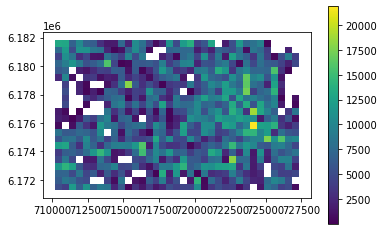

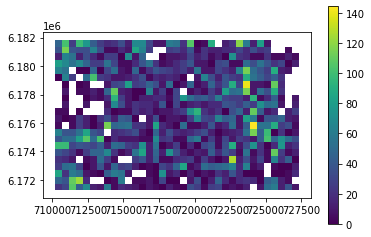

In [11]:
# OSM: Density per gridcell

results_dict = {}
data = (osm_edges_simp_joined, osm_nodes_simp_joined.set_index('osmid'))
[ef.run_grid_analysis(
    grid_id, 
    data, 
    results_dict, 
    ef.compute_network_density, 
    grid['geometry'].loc[grid.grid_id==grid_id].area.values[0], 
    return_dangling_nodes=True) 
for grid_id in grid_ids];

results_df = pd.DataFrame.from_dict(results_dict, orient='index')
results_df.reset_index(inplace=True)
results_df.rename(
    columns={
        'index':'grid_id', 
        0:'osm_edge_density',
        1:'osm_node_density'}, 
    inplace=True)

grid = grid.merge(results_df, on='grid_id', how='left')


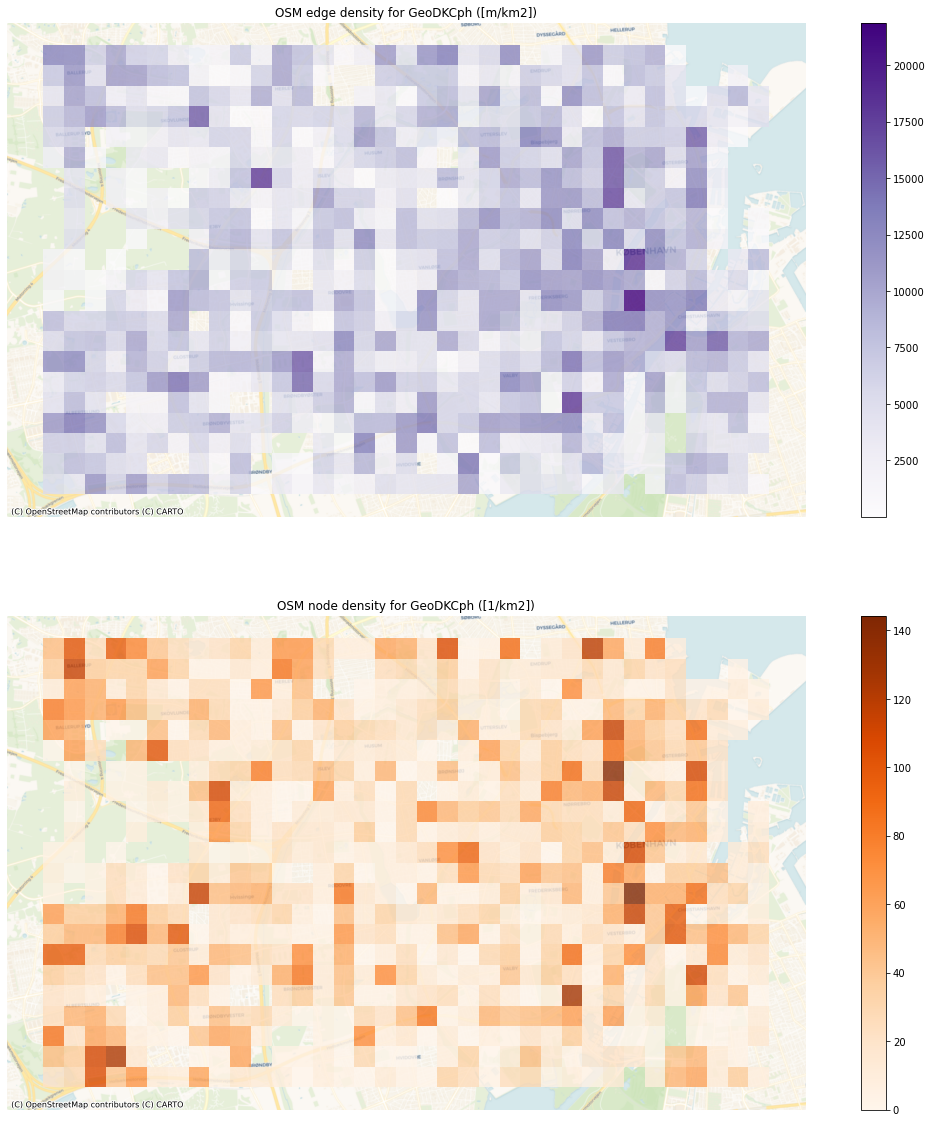

In [18]:
fig, ax = plt.subplots(2,1,figsize=(20,20))

i = 0
grid.plot(ax = ax[i], column='osm_edge_density', legend=True, alpha = 0.8, cmap = 'Purples')
cx.add_basemap(ax = ax[i], crs=study_crs, source=cx.providers.CartoDB.Voyager)
ax[i].set_title('OSM edge density for ' + study_area + " [m/km2]")
ax[i].set_axis_off()

i = 1
grid.plot(ax = ax[i], column='osm_node_density', legend=True, alpha = 0.8, cmap = 'Oranges')
cx.add_basemap(ax = ax[i], crs=study_crs, source=cx.providers.CartoDB.Voyager)
ax[i].set_title('OSM node density for ' + study_area + " [1/km2]")
ax[i].set_axis_off()

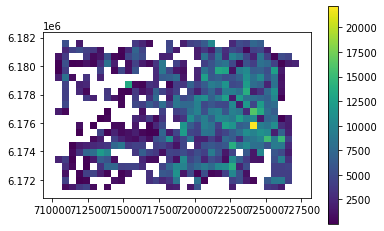

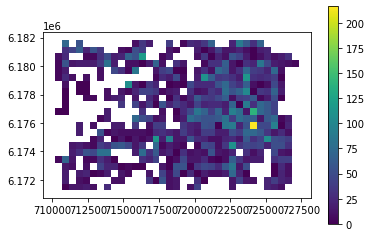

In [12]:
# REF: Density per gridcell

results_dict = {}
data = (ref_edges_simp_joined, ref_nodes_simp_joined.set_index('osmid'))

[ef.run_grid_analysis(
    grid_id, 
    data, 
    results_dict, 
    ef.compute_network_density, 
    grid['geometry'].loc[grid.grid_id==grid_id].area.values[0], 
    return_dangling_nodes=True) 
for grid_id in grid_ids];

results_df = pd.DataFrame.from_dict(results_dict, orient='index')
results_df.reset_index(inplace=True)
results_df.rename(
    columns = {
        'index':'grid_id', 
        0:'ref_edge_density',
        1:'ref_node_density'}, 
    inplace=True)

grid = grid.merge(results_df, on='grid_id', how='left')

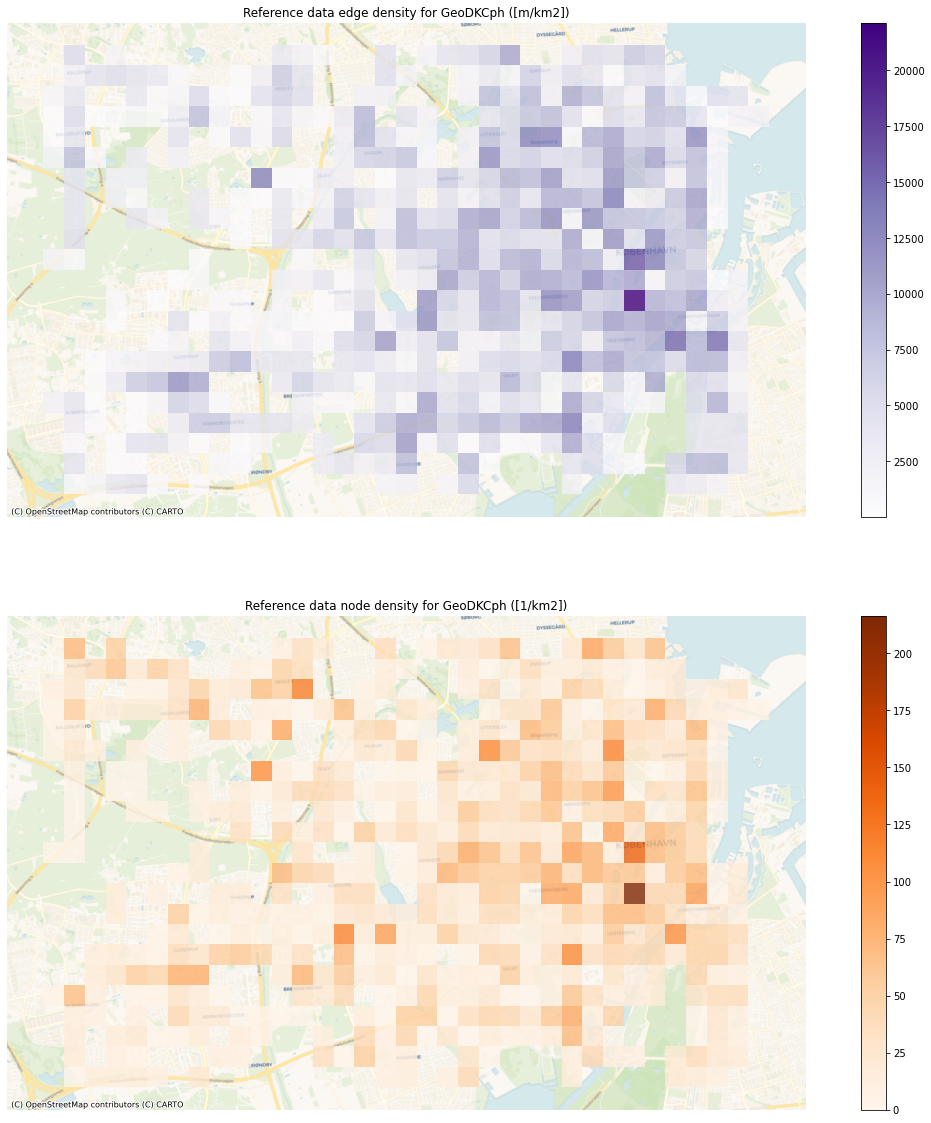

In [19]:
fig, ax = plt.subplots(2,1,figsize=(20,20))

i = 0
grid.plot(ax = ax[i], column='ref_edge_density', legend=True, alpha = 0.8, cmap = 'Purples')
cx.add_basemap(ax = ax[i], crs=study_crs, source=cx.providers.CartoDB.Voyager)
ax[i].set_title('Reference data edge density for ' + study_area + " [m/km2]")
ax[i].set_axis_off()

i = 1
grid.plot(ax = ax[i], column='ref_node_density', legend=True, alpha = 0.8, cmap = 'Oranges')
cx.add_basemap(ax = ax[i], crs=study_crs, source=cx.providers.CartoDB.Voyager)
ax[i].set_title('Reference data node density for ' + study_area + " [1/km2]")
ax[i].set_axis_off()

##### Local differences in network density

In [20]:
grid['edge_density_diff'] = grid.osm_edge_density.fillna(value=0) - grid.ref_edge_density.fillna(value=0)
grid['node_density_diff'] = grid.osm_node_density.fillna(value=0) - grid.ref_node_density.fillna(value=0)

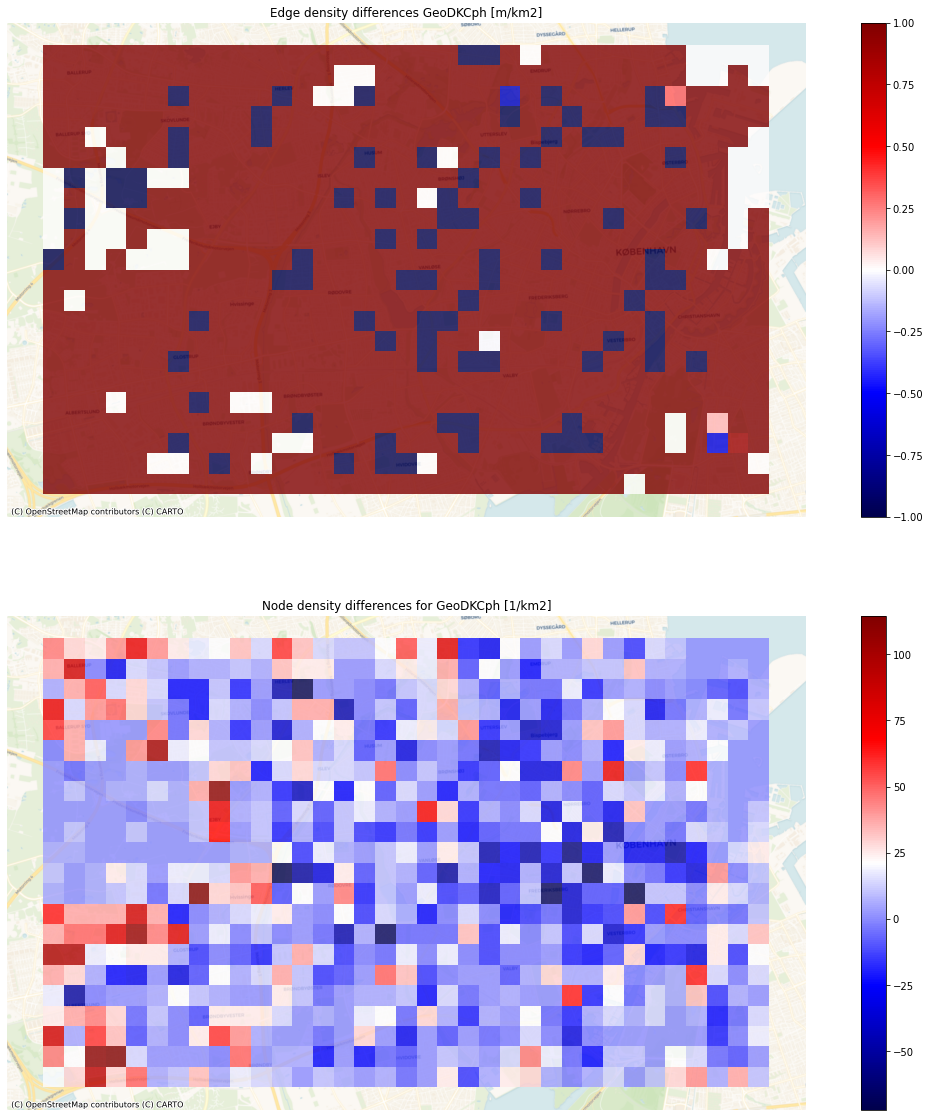

In [27]:
# PLOT DIFFERENCES
#@Ane: under construction - need to norm colorbar differently
# fig, ax = plt.subplots(2,1,figsize=(20,20))

# i = 0
# grid.plot(ax = ax[i], column='edge_density_diff', legend=True, alpha = 0.8, cmap = 'seismic', norm = colors.CenteredNorm())
# cx.add_basemap(ax = ax[i], crs=study_crs, source=cx.providers.CartoDB.Voyager)
# ax[i].set_title('Edge density differences ' + study_area + " [m/km2]")
# ax[i].set_axis_off()

# i = 1
# grid.plot(ax = ax[i], column='node_density_diff', legend=True, alpha = 0.8, cmap = 'seismic')
# cx.add_basemap(ax = ax[i], crs=study_crs, source=cx.providers.CartoDB.Voyager)
# ax[i].set_title('Node density differences for ' + study_area + " [1/km2]")
# ax[i].set_axis_off()

#### Differences in network density for protected vs. unprotected infrastructure

##### Global Network Density for protected vs. unprotected infrastructure

In [18]:
osm_protected = osm_edges_simp_joined.loc[osm_edges_simp_joined.protected=='protected']
osm_unprotected = osm_edges_simp_joined.loc[osm_edges_simp_joined.protected=='unprotected']
osm_mixed = osm_edges_simp_joined.loc[osm_edges_simp_joined.protected=='mixed']

ref_protected = ref_edges_simp_joined.loc[ref_edges_simp_joined.protected=='protected']
ref_unprotected = ref_edges_simp_joined.loc[ref_edges_simp_joined.protected=='unprotected']
ref_mixed = ref_edges_simp_joined.loc[ref_edges_simp_joined.protected=='mixed']

osm_data = [osm_protected, osm_unprotected, osm_mixed]
ref_data = [ref_protected, ref_unprotected, ref_mixed]

labels = ['protected_density', 'unprotected_density','mixed_density']

for data, label in zip(osm_data, labels):
    if len(data) > 0:
        osm_edge_density_type, _ = ef.compute_network_density((data, osm_nodes_simplified),grid.unary_union.area, return_dangling_nodes=False)
        results_osm[label+'_m_sqkm'] = osm_edge_density_type

        print(f'Density for {label}: {osm_edge_density_type:.2f} in OSM data')

for data, label in zip(ref_data, labels):
    if len(data) > 0:
        ref_edge_density_type, _ = ef.compute_network_density((data, ref_nodes_simplified),grid.unary_union.area, return_dangling_nodes=False)
        results_ref[label+'_m_sqkm'] = ref_edge_density_type

        print(f'Density for {label}: {ref_edge_density_type:.2f} in reference data')


Density for protected_density: 5307.11 in OSM data
Density for unprotected_density: 509.51 in OSM data
Density for mixed_density: 54.54 in OSM data
Density for protected_density: 2996.63 in reference data
Density for unprotected_density: 440.92 in reference data


##### Local network density for protected vs. unprotected infrastructure

In [19]:
osm_labels = ['osm_protected_density', 'osm_unprotected_density','osm_mixed_density']
ref_labels = ['ref_protected_density', 'ref_unprotected_density','ref_mixed_density']

for data, label in zip(osm_data, osm_labels):
    if len(data) > 0:
        results_dict = {}
        data = (osm_edges_simp_joined.loc[data.index], osm_nodes_simp_joined)
        [ef.run_grid_analysis(grid_id, data, results_dict, ef.compute_network_density, grid['geometry'].loc[grid.grid_id==grid_id].area.values[0]) for grid_id in grid_ids];

        results_df = pd.DataFrame.from_dict(results_dict, orient='index')
        results_df.reset_index(inplace=True)
        results_df.rename(columns={'index':'grid_id', 0:label}, inplace=True)
        results_df.drop(1,axis=1,inplace=True)

        grid = grid.merge(results_df, on='grid_id', how='left')

for data, label in zip(ref_data, ref_labels):
    if len(data) > 0:
        results_dict = {}
        data = (osm_edges_simp_joined.loc[data.index], osm_nodes_simp_joined)
        [ef.run_grid_analysis(grid_id, data, results_dict, ef.compute_network_density, grid['geometry'].loc[grid.grid_id==grid_id].area.values[0]) for grid_id in grid_ids];

        results_df = pd.DataFrame.from_dict(results_dict, orient='index')
        results_df.reset_index(inplace=True)
        results_df.rename(columns={'index':'grid_id', 0:label}, inplace=True)
        results_df.drop(1,axis=1,inplace=True)

        grid = grid.merge(results_df, on='grid_id', how='left')

# In case no infrastructure with mixed protected/unprotected exist
if 'osm_mixed_density' not in grid.columns:
    print('No streets mapped as mixed protected/unprotected in OSM data')
    grid['osm_mixed_density'] = 0

if 'ref_mixed_density' not in grid.columns:
    print('No streets mapped as mixed protected/unprotected in reference data')
    grid['ref_mixed_density'] = 0

grid['protected_density_diff'] = grid.osm_protected_density.fillna(value=0) - grid.ref_protected_density.fillna(value=0)
grid['unprotected_density_diff'] = grid.osm_unprotected_density.fillna(value=0) - grid.ref_unprotected_density.fillna(value=0)
grid['mixed_density_diff'] = grid.osm_mixed_density.fillna(value=0) - grid.ref_mixed_density.fillna(value=0)

No streets mapped as mixed protected/unprotected in reference data


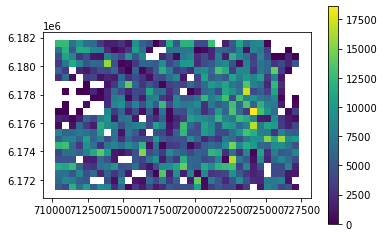

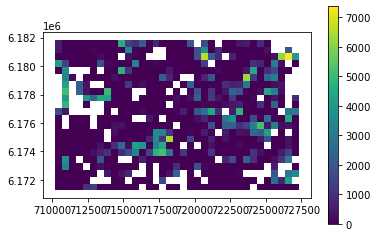

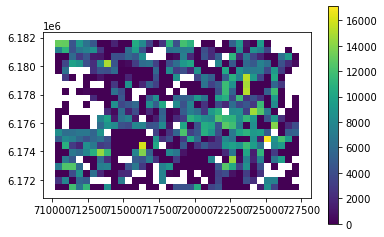

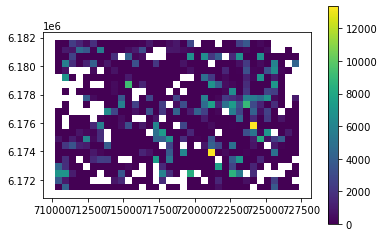

In [20]:
# TODO: format plotting
grid.plot(column='osm_protected_density', legend=True)
grid.plot(column='osm_unprotected_density', legend=True)

grid.plot(column='ref_protected_density', legend=True)
grid.plot(column='ref_unprotected_density', legend=True);

#### Differences in network density for protected vs. unprotected infrastructure

Positive values indicate that the OSM density of the infrastructure type is higher than the reference density, negative values that the OSM density is lower.

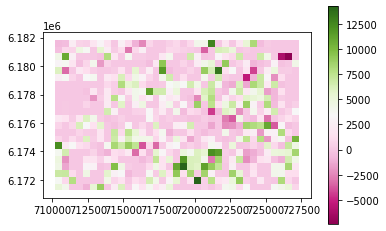

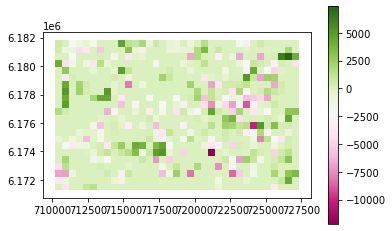

In [21]:
# TODO: Format plotting OBS! If they go below zero, as with node diff here, this should be emphasized!

grid.plot(column='protected_density_diff', legend=True, cmap='PiYG')
grid.plot(column='unprotected_density_diff', legend=True, cmap='PiYG');

___________________

## 3. Network structure

While the section above has tried to give the tools answer how much the two datasets differ in terms of how much infrastructure they describe, the section below will focus on qualitative differences in how the infrastructure is mapped.

### What?

### How?

### What could it mean?

### Alpha, beta and gamma

The network metrics alpha, beta and gamma descripe respectively describe:
- Alpha: "A measure of connectivity which evaluates the number of cycles in a graph in comparison with the maximum number of cycles. The higher the alpha index, the more a network is connected"
- Beta: "Measures the level of connectivity in a graph and is expressed by the relationship between the number of edges over the number of nodes." A higher beta value indicates a more complex network.
- Gamma: "A measure of connectivity that considers the relationship between the number of observed links and the number of possible links" ([Ducruet and Rodrigue, 2020](https://transportgeography.org/contents/methods/graph-theory-measures-indices/))

These metrics do not say much about the data quality itself, but if they are very similiar for the two networks, despite the network e.g. having very different lengths, this suggests that the data sets have been mapped in roughly the same way, but than one simply includes more features than the other. 

On the other hand, ff the networks are roughly the same size but the values from alpha, beta and gamma differ, this can be an indication that the structure and topology of the two datasets are fundamentally different.

In [22]:
osm_alpha, osm_beta, osm_gamma = ef.compute_alpha_beta_gamma(osm_edges_simplified, osm_nodes_simplified, planar=True)

print(f'Alpha for the simplified OSM network is: {osm_alpha:.2f}')
print(f'Beta for the simplified OSM network is: {osm_beta:.2f}')
print(f'Gamma for the simplified OSM network is: {osm_gamma:.2f}')

ref_alpha, ref_beta, ref_gamma = ef.compute_alpha_beta_gamma(ref_edges_simplified, ref_nodes_simplified, planar=True)

print(f'Alpha for the simplified reference network is: {ref_alpha:.2f}')
print(f'Beta for the simplified reference network is: {ref_beta:.2f}')
print(f'Gamma for the simplified reference network is: {ref_gamma:.2f}')


results_osm['alpha'] = osm_alpha
results_osm['beta'] = osm_beta
results_osm['gamma'] = osm_gamma

results_ref['alpha'] = ref_alpha
results_ref['beta'] = ref_beta
results_ref['gamma'] = ref_gamma


Alpha for the simplified OSM network is: 0.08
Beta for the simplified OSM network is: 1.16
Gamma for the simplified OSM network is: 0.39
Alpha for the simplified reference network is: 0.08
Beta for the simplified reference network is: 1.15
Gamma for the simplified reference network is: 0.38


### Simplification outcomes

In [23]:
osm_edge_percent_diff = (len(osm_edges) - len(osm_edges_simplified)) / len(osm_edges)*100
osm_node_percent_diff = (len(osm_nodes) - len(osm_nodes_simplified)) / len(osm_nodes)*100
print(f'Simplifying the OSM network decreased the number of edges with {osm_edge_percent_diff:.1f}%')
print(f'Simplifying the OSM network decreased the number of nodes with {osm_node_percent_diff:.1f}%')

ref_edge_percent_diff = (len(ref_edges) - len(ref_edges_simplified)) / len(ref_edges)*100
ref_node_percent_diff = (len(ref_nodes) - len(ref_nodes_simplified)) / len(ref_nodes)*100
print(f'Simplifying the reference network decreased the number of edges with {ref_edge_percent_diff:.1f}%')
print(f'Simplifying the reference network decreased the number of nodes with {ref_node_percent_diff:.1f}%')


results_osm['simplified_edge_pct_diff'] = osm_edge_percent_diff
results_osm['simplified_node_pct_diff'] = osm_node_percent_diff

results_ref['simplified_edge_pct_diff'] = ref_edge_percent_diff
results_ref['simplified_node_pct_diff'] = ref_node_percent_diff

Simplifying the OSM network decreased the number of edges with 89.0%
Simplifying the OSM network decreased the number of nodes with 84.7%
Simplifying the reference network decreased the number of edges with 60.2%
Simplifying the reference network decreased the number of nodes with 63.5%


### Number of nodes and edges per infrastructure length

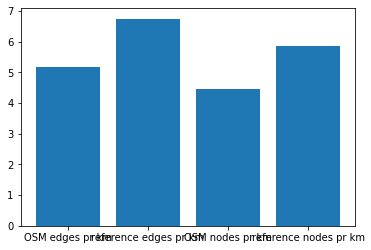

In [24]:
# TODO Should it be geometric length instead?

osm_nodes_count = len(osm_nodes_simplified)
osm_edges_count = len(osm_edges_simplified)

ref_nodes_count = len(ref_nodes_simplified)
ref_edges_count = len(ref_edges_simplified)

ref_total_length = ref_edges_simplified.infrastructure_length.sum() / 1000
osm_total_length = osm_edges_simplified.infrastructure_length.sum() / 1000

ref_edges_pr_km = ref_edges_count/ref_total_length
osm_edges_pr_km = osm_edges_count/osm_total_length

ref_nodes_pr_km = ref_nodes_count/ref_total_length
osm_nodes_pr_km = osm_nodes_count/osm_total_length

values = [osm_edges_pr_km, ref_edges_pr_km, osm_nodes_pr_km, ref_nodes_pr_km]
labels = ['OSM edges pr km','reference edges pr km', 'OSM nodes pr km', 'reference nodes pr km']


results_osm['edges_pr_km'] = osm_edges_pr_km
results_ref['edges_pr_km'] = ref_edges_pr_km
results_osm['nodes_pr_km'] = osm_nodes_pr_km
results_ref['nodes_pr_km'] = ref_nodes_pr_km

# TODO format plot
plt.bar(range(len(values)), values, tick_label=labels);


### Local node/edge ratio

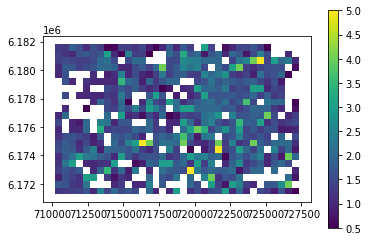

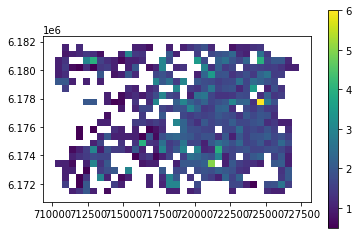

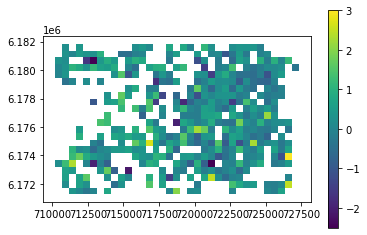

In [25]:
# Per grid cell
results_dict = {}
data = (osm_edges_simp_joined, osm_nodes_simp_joined)
[ef.run_grid_analysis(grid_id, data, results_dict, ef.compute_edge_node_ratio) for grid_id in grid_ids];

results_df = pd.DataFrame.from_dict(results_dict, orient='index')
results_df.reset_index(inplace=True)
results_df.rename(columns={'index':'grid_id', 0:'osm_edge_node_ratio'}, inplace=True)

grid = grid.merge(results_df, on='grid_id', how='left')

results_dict = {}
data = (ref_edges_simp_joined, ref_nodes_simp_joined)
[ef.run_grid_analysis(grid_id, data, results_dict, ef.compute_edge_node_ratio) for grid_id in grid_ids];

results_df = pd.DataFrame.from_dict(results_dict, orient='index')
results_df.reset_index(inplace=True)
results_df.rename(columns={'index':'grid_id', 0:'ref_edge_node_ratio'}, inplace=True)

grid = grid.merge(results_df, on='grid_id', how='left')

grid['edge_node_ratio_diff'] = grid.osm_edge_node_ratio - grid.ref_edge_node_ratio

# TODO: Format plotting
grid.plot(column='osm_edge_node_ratio', legend=True);
grid.plot(column='ref_edge_node_ratio', legend=True);
grid.plot(column='edge_node_ratio_diff', legend=True);

____________________________

## 4. Network topology

### Why?

### What?

### What does it mean?

### Dangling nodes & under/overshoots

# TO DO INSERT EXPL

A dangling node in a network is all the start and end nodes - in other words, nodes that do not represent intersections between edges, but indicates where an edge begins or ends.

Most networks will naturally contain a number of dangling nodes. How many does to some extent depend on the digitization method (*see illustration below for how the digitization method determines whether a dangling node wil occur.*)

The presence of dangling nodes are thus in itself not a sign of low data quality, but a high number in an area that is not known for suffering from many dead-ends can indicate digitization errors and problems with edge under- and overshoot (see below or GIS Lounge for an [explanation of under- and overshoots](https://www.gislounge.com/digitizing-errors-in-gis/)).

When two nodes in a simplified network are placed within a distance of a few meters, but do not share a common edge, we often have a case of an edge over/under shoot or another digitizing error.

Based on Barron et al., 2013.

- Not always a problem - the feature might play a role - but overshoots can skew the analysis of network structure
- Undershoots a problem for any routing that only considers cycling infrastructure

<img src='../images/dangling_nodes_illustration.png' height=200 />  <img src='../images/no_dangling_nodes_illustration.png' height=200 />

*Dangling nodes occur where road features end (left), but when separate features are joined at the end (right), there will be no dangling nodes*

<img src='../images/overshoot_illustration.png' height=200 />  <img src='../images/undershoot_illustration.png' height=200 />

*Overshoots refer to situations where a line feature extends too far beyond at intersecting line, rather than ending at the intersection (left).* 
*Undershoots happen when two line features are not properly joined, for example at at intersection (right)*

### Dangling nodes

#### Dangling nodes - global

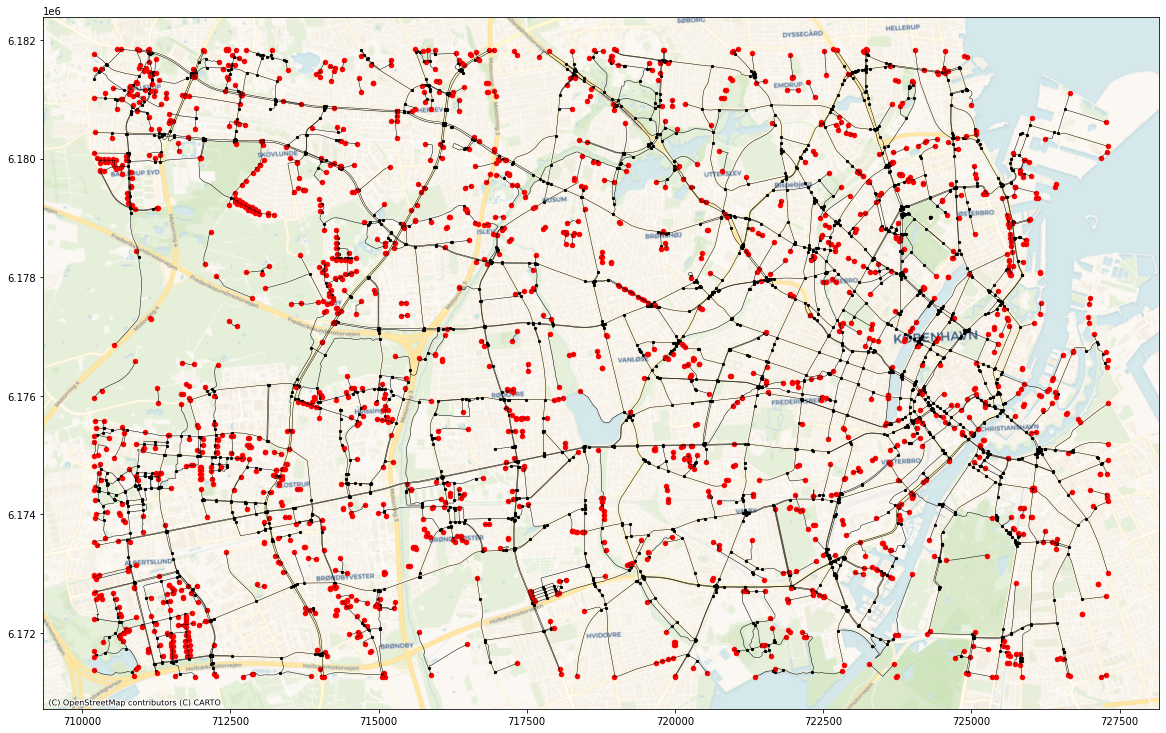

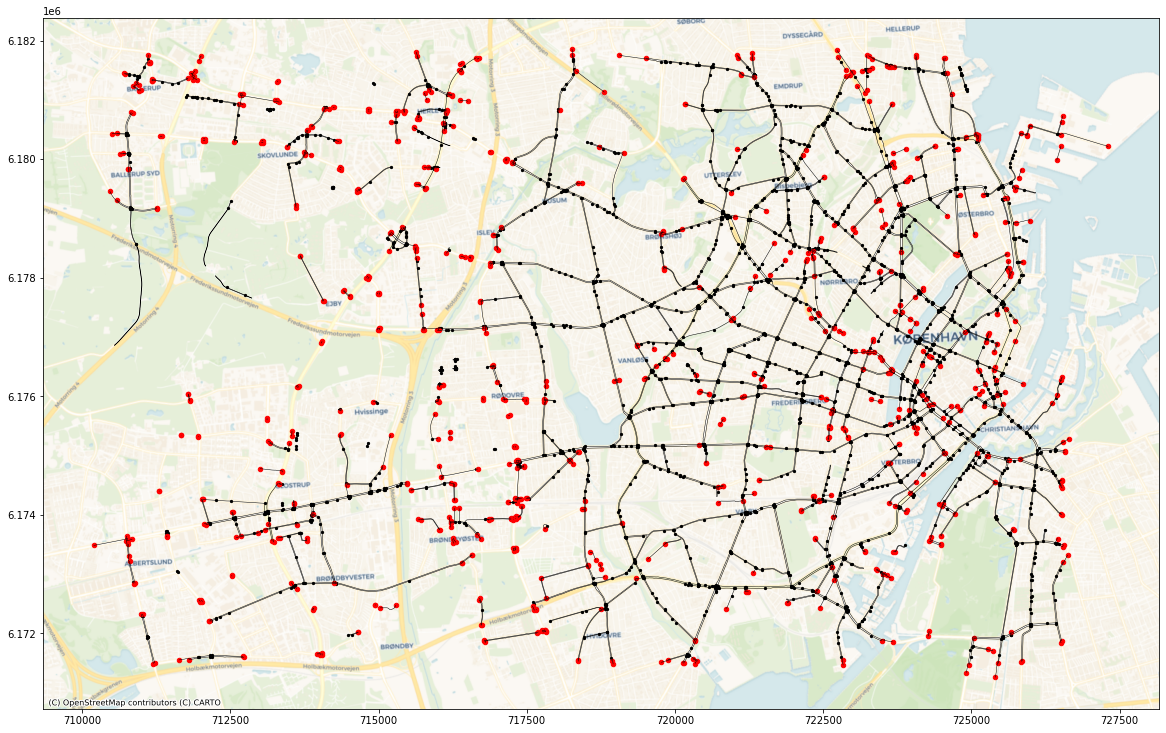

In [26]:
osm_dangling_nodes = ef.get_dangling_nodes(osm_edges_simplified, osm_nodes_simplified)

fig, ax = plt.subplots(1, figsize=(20,20))

osm_edges_simplified.plot(ax=ax, color='black', linewidth=0.5)
osm_nodes_simplified.plot(ax=ax, color='black', markersize=5)
osm_dangling_nodes.plot(ax=ax, color='red', markersize=20)

cx.add_basemap(
        ax, 
        crs=osm_edges_simplified.crs, 
        source=cx.providers.CartoDB.Voyager
    )


ref_dangling_nodes = ef.get_dangling_nodes(ref_edges_simplified, ref_nodes_simplified)

fig, ax = plt.subplots(1, figsize=(20,20))

ref_edges_simplified.plot(ax=ax, color='black', linewidth=0.5)
ref_nodes_simplified.plot(ax=ax, color='black', markersize=5)
ref_dangling_nodes.plot(ax=ax, color='red', markersize=20)

cx.add_basemap(
        ax, 
        crs=osm_edges_simplified.crs, 
        source=cx.providers.CartoDB.Voyager
    )

results_osm['dangling_node_count'] = len(osm_dangling_nodes)
results_ref['dangling_node_count'] = len(ref_dangling_nodes)

#### Dangling nodes - local



Node/dangling node ratio?

In [28]:
grid.columns

Index(['grid_id', 'count_osm_edges', 'count_osm_nodes',
       'count_osm_simplified_edges', 'count_osm_simplified_nodes',
       'count_ref_edges_x', 'count_ref_nodes_x',
       'count_ref_simplified_edges_x', 'count_ref_simplified_nodes_x',
       'count_ref_edges_y', 'count_ref_nodes_y',
       'count_ref_simplified_edges_y', 'count_ref_simplified_nodes_y',
       'count_ref_edges', 'count_ref_nodes', 'count_ref_simplified_edges',
       'count_ref_simplified_nodes', 'geometry', 'osm_edge_density',
       'osm_node_density', 'ref_edge_density', 'ref_node_density',
       'edge_density_diff', 'node_density_diff', 'osm_protected_density',
       'osm_unprotected_density', 'osm_mixed_density', 'ref_protected_density',
       'ref_unprotected_density', 'ref_mixed_density',
       'protected_density_diff', 'unprotected_density_diff',
       'mixed_density_diff', 'osm_edge_node_ratio', 'ref_edge_node_ratio',
       'edge_node_ratio_diff', 'count_osm_dangling_nodes',
       'count_ref_dang

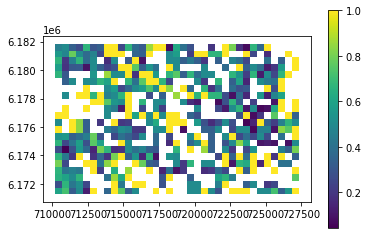

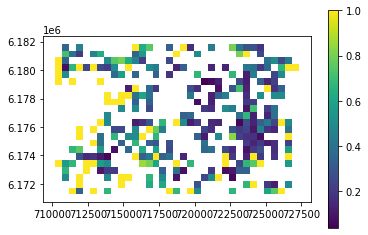

In [31]:
dn_osm_joined = gpd.overlay(osm_dangling_nodes, grid[['geometry','grid_id']], how ='intersection')
df = ef.count_features_in_grid(dn_osm_joined,'osm_dangling_nodes')
grid = grid.merge(df, on='grid_id', how='left')

dn_ref_joined = gpd.overlay(ref_dangling_nodes, grid[['geometry','grid_id']], how ='intersection')
df = ef.count_features_in_grid(dn_ref_joined,'ref_dangling_nodes')
grid = grid.merge(df, on='grid_id', how='left')

grid['osm_dangling_nodes_per_node'] = grid.count_osm_dangling_nodes / grid.count_osm_simplified_nodes
grid['ref_dangling_nodes_per_node'] = grid.count_ref_dangling_nodes / grid.count_ref_simplified_nodes

grid['dangling_node_ratio_diff'] = grid.osm_dangling_nodes_per_node - grid.ref_dangling_nodes_per_node

grid.plot(column='osm_dangling_nodes_per_node',legend=True)
grid.plot(column='ref_dangling_nodes_per_node',legend=True);

### Overshoots

# TODO INSERT EXPL

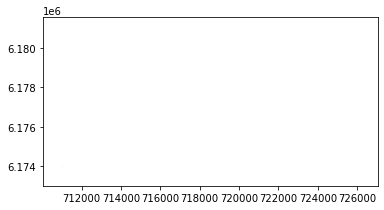

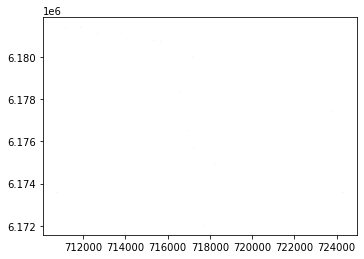

In [32]:
osm_overshoots = ef.find_overshoots(osm_dangling_nodes, osm_edges_simplified, 3)
ref_overshoots = ef.find_overshoots(ref_dangling_nodes, ref_edges_simplified, 3)

results_osm['count_overshoots'] = len(osm_overshoots)
results_ref['count_overshoots'] = len(ref_overshoots)

osm_overshoots.plot();
# TODO: Make Folium plot - should be possible to zoom in!

ref_overshoots.plot();
# TODO: Make Folium plot - should be possible to zoom in!

### Undershoots

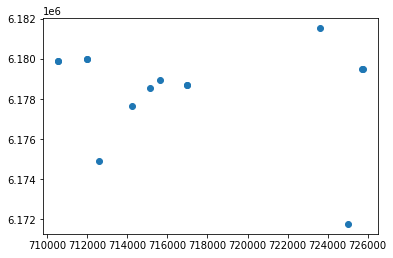

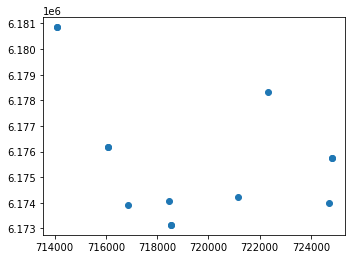

In [33]:
osm_undershoot_dict, osm_undershoot_nodes = ef.find_undershoots(osm_dangling_nodes, osm_edges_simplified, 3,'edge_id')

ref_undershoot_dict, ref_undershoot_nodes = ef.find_undershoots(ref_dangling_nodes, ref_edges_simplified, 3,'edge_id')

results_osm['count_undershoots'] = len(osm_undershoot_nodes)
results_ref['count_undershoots'] = len(ref_undershoot_nodes)

osm_undershoot_nodes.plot();
ref_undershoot_nodes.plot();

# TODO: make folium plt

__________________

## 5.Network component analysis

### What?

### How?

### What could it mean?

### Number of connected components

The OSM network in the study area consists of 346 unconnected components.


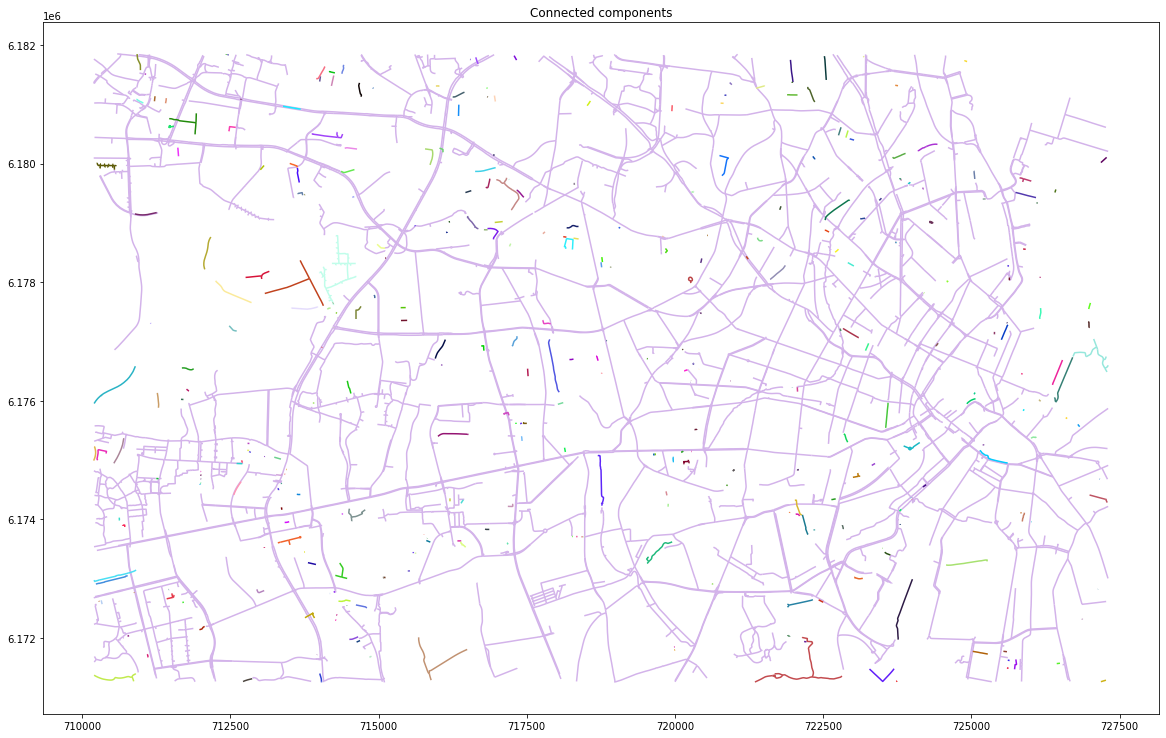

The reference network in the study area consists of 195 unconnected components.


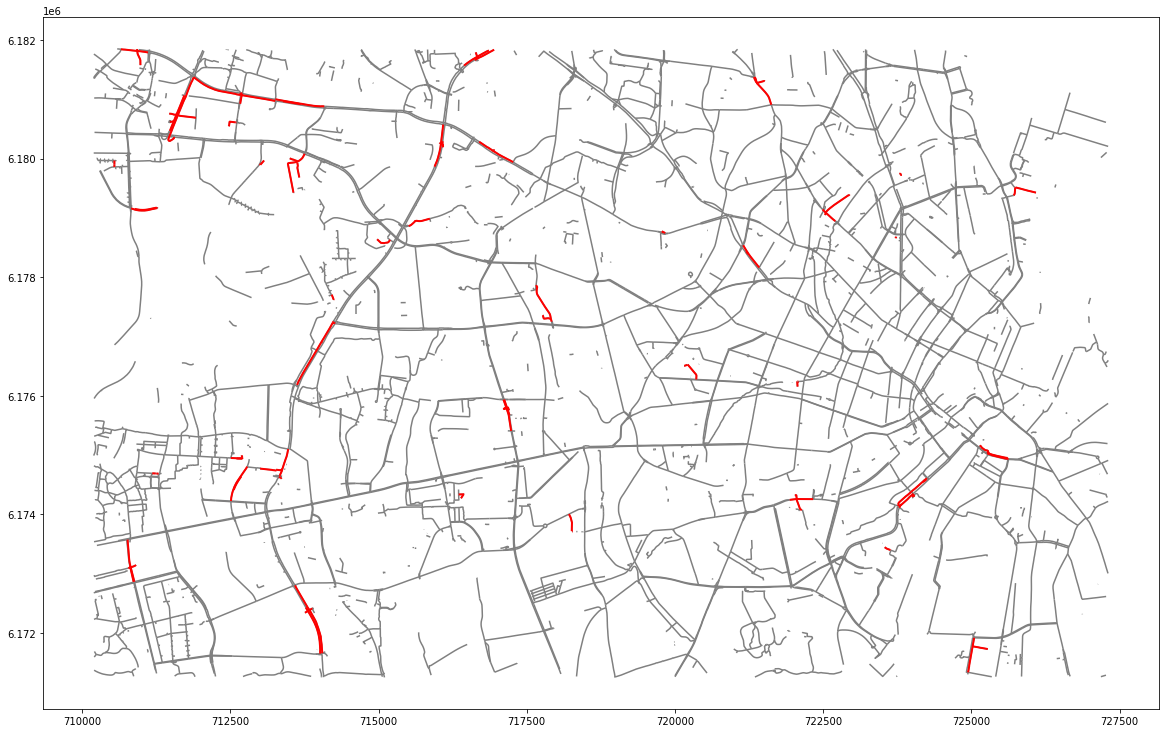

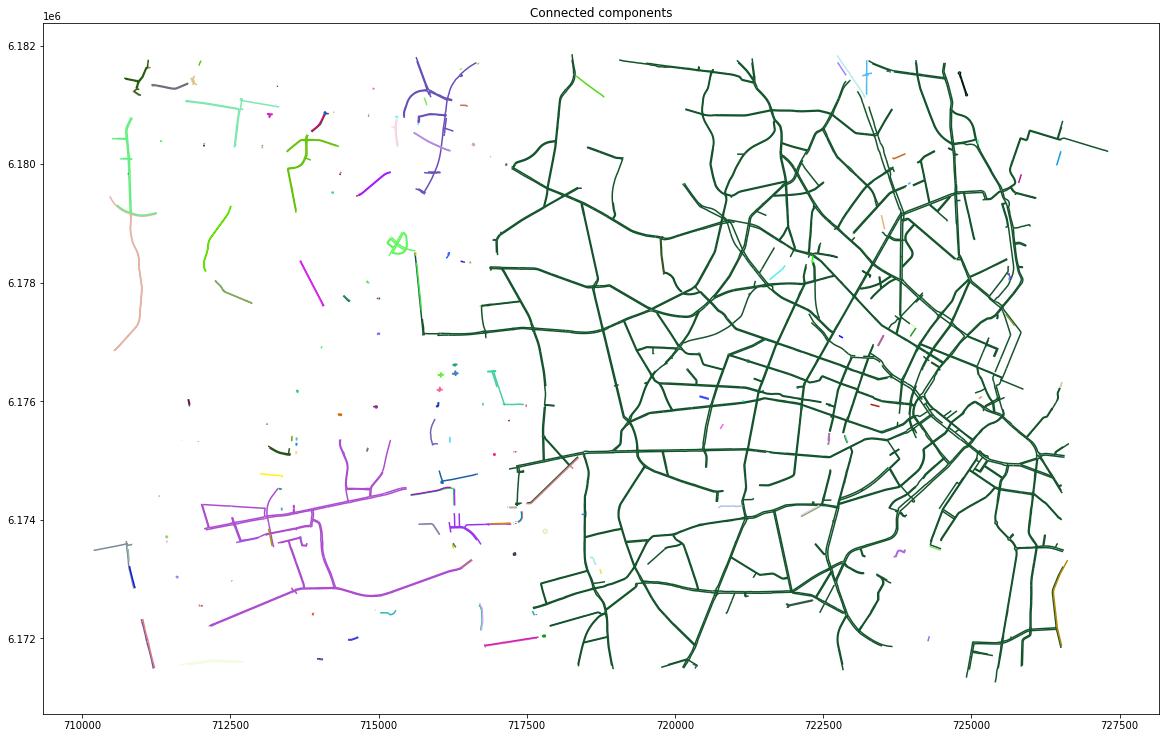

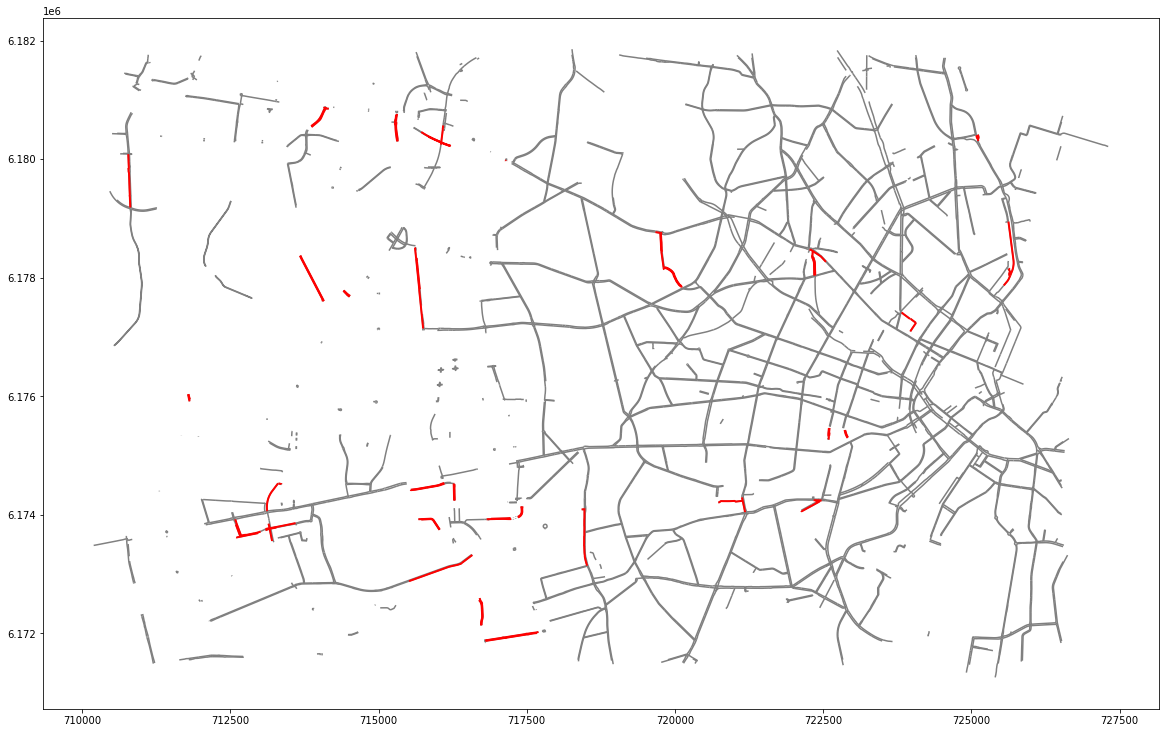

In [35]:
# TODO: Compare plots of unconnected issues!

osm_components = ef.return_components(osm_simplified_graph)
print(f'The OSM network in the study area consists of {len(osm_components)} unconnected components.')

components_plot = ef.plot_components(osm_components)

osm_comp_issues = ef.find_adjacent_components(components=osm_components, buffer_dist=10, edge_id='edge_id', crs=study_crs)

fig, ax = plt.subplots(figsize=(20,20))

osm_edges_simplified.plot(ax=ax, color='grey');
osm_comp_issues.plot(ax=ax, color='red', linewidth=2);

# TODO: Fix plot - plot with unconnected components as well

ref_components = ef.return_components(ref_simplified_graph)
print(f'The reference network in the study area consists of {len(ref_components)} unconnected components.')

components_plot = ef.plot_components(ref_components)

ref_comp_issues = ef.find_adjacent_components(components=ref_components, buffer_dist=10, edge_id='edge_id', crs=study_crs)

fig, ax = plt.subplots(figsize=(20,20))

ref_edges_simplified.plot(ax=ax, color='grey');
ref_comp_issues.plot(ax=ax, color='red', linewidth=2);

# TODO: Fix plot - plot with unconnected ref_components as well

### Component size distribution

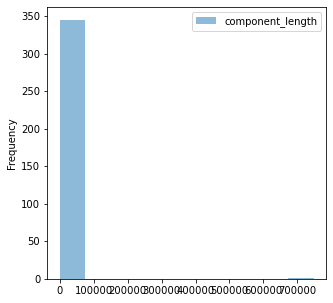

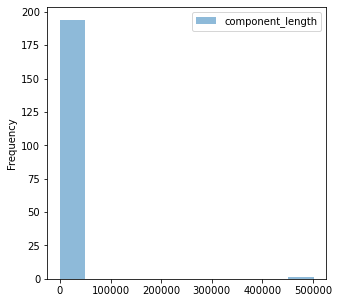

In [36]:
osm_components_df = ef.component_lengths(osm_components)
ax = osm_components_df.plot.hist(column='component_length', bins=10, alpha=0.5, figsize = (5,5))

ref_components_df = ef.component_lengths(ref_components)
ax = ref_components_df.plot.hist(column='component_length', bins=10, alpha=0.5, figsize = (5,5))

### Largest connected component

In [37]:
osm_largest_cc = max(osm_components, key=len)

osm_largest_cc_length = 0

for (u, v, l) in osm_largest_cc.edges(data='length'):

        osm_largest_cc_length += l

osm_largest_cc_pct = osm_largest_cc_length / osm_components_df['component_length'].sum() * 100

print(f'The largest connected component in the OSM network contains {osm_largest_cc_pct:.2f} % of the network length.')

ref_largest_cc = max(ref_components, key=len)

ref_largest_cc_length = 0

for (u, v, l) in ref_largest_cc.edges(data='length'):

        ref_largest_cc_length += l

ref_largest_cc_pct = ref_largest_cc_length / ref_components_df['component_length'].sum() * 100

print(f'The largest connected component in the reference network contains {ref_largest_cc_pct:.2f} % of the network length.')

# TODO Add plot comparing the two. And maybe plot just the largest ones?

The largest connected component in the OSM network contains 92.63 % of the network length.
The largest connected component in the reference network contains 80.40 % of the network length.


### Edge number distribution

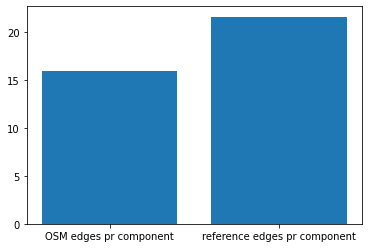

In [38]:
osm_edge_component_ratio =  len(osm_edges_simplified) / len(osm_components)
ref_edge_component_ratio = len(ref_edges_simplified) / len(ref_components)

values = [osm_edge_component_ratio, ref_edge_component_ratio]
labels = ['OSM edges pr component','reference edges pr component']

# TODO format plot
plt.bar(range(len(values)), values, tick_label=labels);

Assign component id to grid:

In [54]:
grid = ef.assign_component_id_to_grid(osm_edges_simplified, osm_edges_simp_joined, osm_components, grid, prefix='osm', edge_id_col='edge_id')

grid = ef.assign_component_id_to_grid(ref_edges_simplified, ref_edges_simp_joined, ref_components, grid, prefix='ref', edge_id_col='edge_id')

fill_na_dict = {'component_ids_osm': '','component_ids_ref': ''}
grid.fillna(value=fill_na_dict,inplace=True)

### Grid cells with more than one component

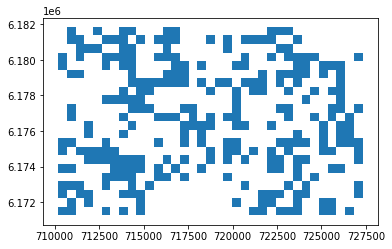

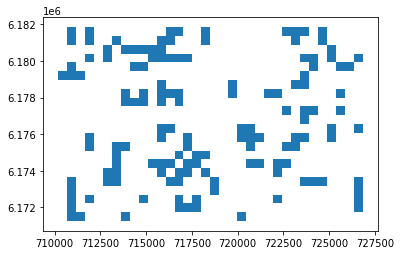

In [55]:
# Cells with more than one component
grid.loc[grid['component_ids_osm'].map(len) > 1].plot();

grid.loc[grid['component_ids_ref'].map(len) > 1].plot();

### Component connectivity

Visualising differences between how many cells can be reached from each cell.
Positive values in the plot means that more cells can be reached from this particular cell using the OSM data, while negative values indicate a higher connectivity using the reference data set.

This is a crude measure for network connectivity, but has the benefit of being computationally cheap and thus able to highlight stark differences in network connectivity in very little time.

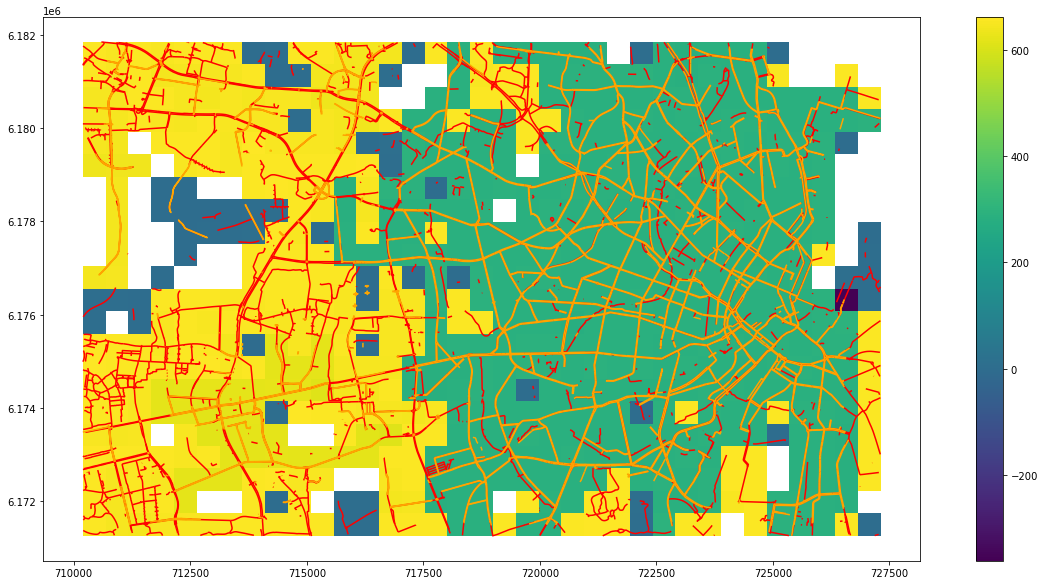

In [57]:
osm_components_cell_count = ef.count_component_cell_reach(osm_components_df, grid, 'component_ids_osm')
grid['cells_reached_osm'] = grid['component_ids_osm'].apply(lambda x: ef.count_cells_reached(x, osm_components_cell_count) if x != '' else 0)

ref_components_cell_count = ef.count_component_cell_reach(ref_components_df, grid, 'component_ids_ref')
grid['cells_reached_ref'] = grid['component_ids_ref'].apply(lambda x: ef.count_cells_reached(x, ref_components_cell_count) if x != '' else 0)

grid['cell_reach_diff'] = grid['cells_reached_osm'] - grid['cells_reached_ref']

mask = grid[(grid.cells_reached_osm==0) & (grid.cells_reached_ref ==0)].index
grid.loc[mask,'cell_reach_diff'] = None

# TODO: Plot
fig, ax = plt.subplots(figsize=(20,10))

grid.plot(ax=ax, column='cell_reach_diff', legend=True)
osm_edges_simplified.plot(ax=ax, color='red')
ref_edges_simplified.plot(ax=ax, color='orange');

In [58]:
# Saving results of component analysis

results_osm['component_count'] = len(osm_components)
results_osm['largest_cc_pct_size'] = osm_largest_cc_pct
results_osm['largest_cc_length_km'] = osm_largest_cc_length / 1000
results_osm['component_gaps'] = len(osm_comp_issues)
results_osm['edge_component_ratio'] = osm_edge_component_ratio

results_ref['component_count'] = len(ref_components)
results_ref['largest_cc_pct_size'] = ref_largest_cc_pct
results_ref['largest_cc_length_km'] = ref_largest_cc_length / 1000
results_ref['component_gaps'] = len(ref_comp_issues)
results_ref['edge_component_ratio'] = ref_edge_component_ratio


________________________

## 6. Save results

In [218]:
all_results['osm_results'] = results_osm
all_results['ref_results'] = results_ref

with open(f'../results/extrinsic_analysis_{study_area}.json', 'w') as outfile:
    json.dump(all_results, outfile)


with open(f'../results/grid_results_extrinsic_{study_area}.pickle', 'wb') as f:
    pickle.dump(grid, f)

__________________

For a summary of core metrics, run the notebook [summary of extrinsic analysis](./summary_extrinsinc_analysis.ipynb).